# Supervised and Unsupervised Classification using Sentinel-2 data

## Introduction

In this workflow we train three supervised and one unsupervised land cover classification models with Sentinel-2 data. The aim is to classify a Sentinel-2 image into four different land cover classes: `water surfaces`, `artificial surfaces`, `low vegetation` and `tree cover`. We use the [scikit-learn](https://scikit-learn.org/stable/) implemenations of these algorithms.

 The supervised classification algorithms used are:
 
* [Decision Tree](https://scikit-learn.org/stable/modules/tree.html): a non-parametric supervised learning method
* [Random Forest](https://scikit-learn.org/stable/modules/ensemble.html): an ensemble classification method, where several predictions of base estimators are combined
* [Support Vector Machine (SVM)](https://scikit-learn.org/stable/modules/svm.html): a set of supervised learning methods used for classification, regression and outliers detection

The unsupervised model used:

- [K-means](https://scikit-learn.org/stable/modules/clustering.html#k-means): a [clustering](https://scikit-learn.org/stable/modules/clustering.html) algorithm, where a set of objects are grouped together in a group (`cluster`) based on their similarities.

The K-means algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. The algorithm requires the number of clusters to be specified in advance. It scales well to large number of samples and has been used across a large range of application areas in many different fields.

## Data

We use a pre-processed Sentinel-2 image for training, testing and inference. The following operations were conducted beforehand on the original image file:

* `Subsetting` to a dimension of `(200, 600)` pixels
* `Resampling` of all 13 bands to a 10 m resolution
* `Saving` the 13 bands as individual `.tif` files

Additionally, a set of training and validation data points have been manually identified:

* [training_points.csv](../data/training_points.csv): 400 labelled training point locations (X and Y) for each of the land cover classes
* [validation_points.csv](../data/validation_points.csv): 100 labelled point locations together with the respective land cover class

Source:

This data was made available as part of the [FutureLearn AI for Earth Monitoring MOOC](https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoringhttps://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring). The unprocessed Sentinel-2 image was made freely available by the [EU’s Copernicus Programme](https://www.copernicus.eu/en) and obtained using their [WEkEO platform](https://wekeo.eu/).

## Further resources

* [Decision Trees - Scikit-learn documentation](https://scikit-learn.org/stable/modules/tree.html)
* [Ensemble methods - Scikit-learn documentation](https://scikit-learn.org/stable/modules/ensemble.html)
* [Support Vector Machines - Scikit-learn documentation](https://scikit-learn.org/stable/modules/svm.html)
* [Unsupervised learning - Scikit-learn documentation](https://scikit-learn.org/stable/unsupervised_learning.html)
* [Clustering - Scikit-learn documentation](https://scikit-learn.org/stable/modules/clustering.html)
* [K-means clustering - Scikit-learn documentation](https://scikit-learn.org/stable/modules/clustering.html#k-means)* [Unsupervised learning - Scikit-learn documentation](https://scikit-learn.org/stable/unsupervised_learning.html)
* [Clustering - Scikit-learn documentation](https://scikit-learn.org/stable/modules/clustering.html)
* [K-means clustering - Scikit-learn documentation](https://scikit-learn.org/stable/modules/clustering.html#k-means)

<hr>

## Notebook outline

* [1 - Load and display a Sentinel-2 image](#load_s2_image_3d2)
* [2 - Load and display training point locations](#load_training_point_3d2)
* [3 - Training data preparation for supervised algorithms](#data_transformation_3d2)
* [4 - Define and train three different supervised training classifiers](#training_classifiers_3d2)
* [5 - Unsupervised classification with K-means clustering](#kmeans_clustering_3d2)
* [6 - Assigning clusters to land cover classes](#assign_clusters_3d2)
* [7 - Classification of the Sentinel-2 image with the trained classifiers](#predict_3d2)
* [8 - Evaluate the classification performance](#evaluate_3d2)

<hr>

#### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import pathlib
import typing as t

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
import skimage.io
import sklearn
import utils
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

<hr>

## <a id='load_s2_image_3d2'></a>1. Load and display a Sentinel-2 image

The first step is to inspect a Sentinel-2 image file, in order to better understand the file structure. Sentinel-2 carries a single `Multi-spectral Instrument (MSI)`, which provides 13 bands in the `visible`, `near-infrared` and `shortwave-infrared` spectrum with different ground resolutions:

In [3]:
print("Band\tRes (m)\tDescription")

for band, info in utils.S2_BANDS.items():
    print(f"{band}\t{info['resolution']}\t{info['description']}")

Band	Res (m)	Description
B1	60	Coastal aerosol
B2	10	Blue
B3	10	Green
B4	10	Red
B5	20	Red Edge 1
B6	20	Red Edge 2
B7	20	Red Edge 3
B8	10	Near-Infrared
B8A	20	Near-Infrared narrow
B9	60	Water vapor
B10	60	Shortwave-Infrared cirrus
B11	20	Shortwave Infrared 1
B12	20	Shortwave-Infrared 2


A pre-processed Sentinel-2 image example is available in the folder `./S2_data/`. Originally, Sentinel-2 files are disseminated in the `SAFE` data format. For this example, the image has been preprocessed and each of the 13 band information saved as `.tif` file. Additionally, all bands were resampled to a resolution of 10m.

In [4]:
DATA_DIR = pathlib.Path("../data")
IMAGE_DIR = DATA_DIR / "S2"
TRAINING_DATA = DATA_DIR / "training_points.csv"
VALIDATION_DATA = DATA_DIR / "validation_points.csv"

In [5]:
image = skimage.io.ImageCollection(str(IMAGE_DIR / "*.tif"))

# a list of loaded files - note band ordering
print(image.files)

['../data/S2/B1.tif', '../data/S2/B2.tif', '../data/S2/B3.tif', '../data/S2/B4.tif', '../data/S2/B5.tif', '../data/S2/B6.tif', '../data/S2/B7.tif', '../data/S2/B8.tif', '../data/S2/B8a.tif', '../data/S2/B9.tif', '../data/S2/B10.tif', '../data/S2/B11.tif', '../data/S2/B12.tif']


In [6]:
# Stack image bands into an array for later use
bands = np.array([np.asarray(band.data) for band in image])

# X_all contains one row per pixel with band values as columns
X_all = bands.reshape((13, -1)).T

bands.shape, X_all.shape

((13, 200, 600), (120000, 13))

Extract composite image using bands in the visible spectrum (B2, B3, B4)

In [7]:
rgb_img = utils.composition(image[3], image[2], image[1])

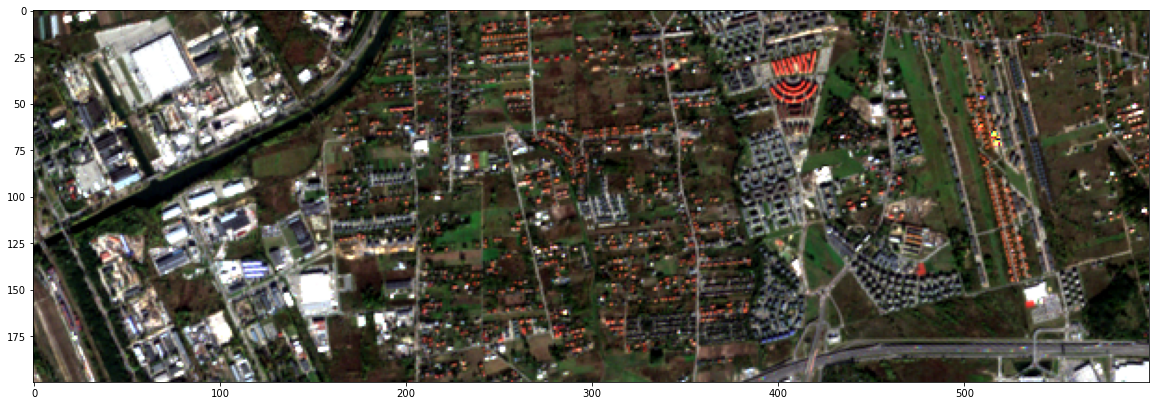

In [8]:
utils.imshow(rgb_img)

<br>

## <a id='load_training_point_3d2'></a>2. Load and display training point locations

Supervised classfications require manually identified training points (labels) of example classes. We aim to classify each pixel of the Sentinel-2 image above into one of four land cover classes: `water`, `artificial surfaces`, `low vegetation`, or `tree cover`.

The file [training_points.csv](../data/training/training_points.csv) gives `(x,y)` pixel coordinates of 400 manually identified training points along with their respective land cover classes.

In [9]:
band_names = list(utils.S2_BANDS)
class_names = [
    "water",
    "artificial",
    "low vegetation",
    "tree cover",
]
class_encoding = dict(zip(class_names, range(1, len(class_names) + 1)))

In [10]:
pixel_classes = pd.read_csv(TRAINING_DATA)
pixel_classes["class_enc"] = pixel_classes.class_name.map(class_encoding)
pixel_classes

x    y  class_name  class_enc
0     59  143       water          1
1     59  142       water          1
2     32   35       water          1
3     32   36       water          1
4     29   34       water          1
..   ...  ...         ...        ...
395  135  231  tree cover          4
396   30  171  tree cover          4
397   31  171  tree cover          4
398   30  172  tree cover          4
399   31  172  tree cover          4

[400 rows x 4 columns]

With the `X` and `Y` pixel coordinate information of the training point, mask and colorize the respective pixels that are used as training point.

In [11]:
rgb_img.shape

(200, 600, 3)

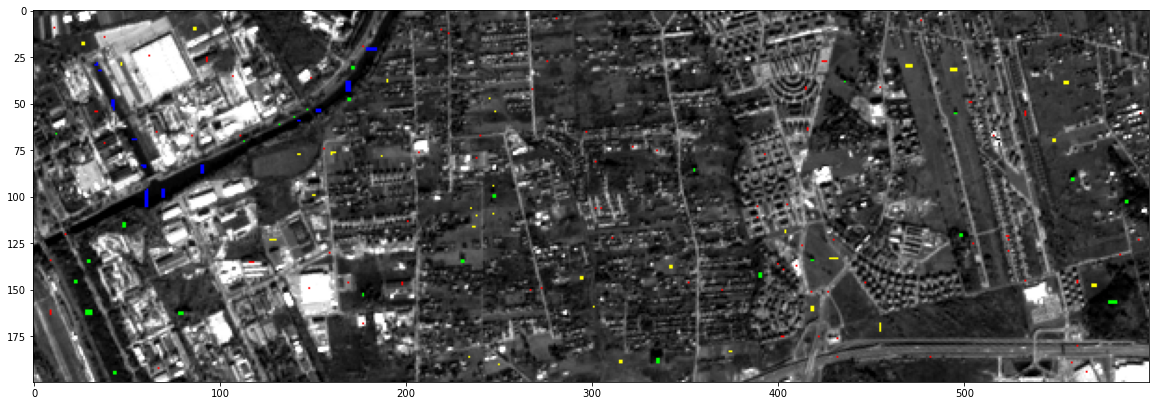

In [12]:
grayscale_img = utils.image_to_grayscale(rgb_img)

px_cls = pixel_classes.set_index("class_name")

utils.mask_pixels_rgb(grayscale_img, px_cls.loc["water"], "blue")
utils.mask_pixels_rgb(grayscale_img, px_cls.loc["artificial"], "red")
utils.mask_pixels_rgb(grayscale_img, px_cls.loc["low vegetation"], "yellow")
utils.mask_pixels_rgb(grayscale_img, px_cls.loc["tree cover"], "green")

utils.imshow(grayscale_img)

<br>

## <a id='data_transformation_3d2'></a>3. Training data preparation for supervised algorithms

The next step is to transform the training labels into a format the ML algorithms will understand. The algorithms require an input (`X`) and output (`y`) variable. The input will be a matrix with dimensions `num samples`x`num features` - here 400x13. Each sample is a single pixel, whose features are the values of the 13 bands for the pixel coordinates taken from the Sentinel-2 image. The output will be an integer in `[1,4]` corresponding to one of the four land cover classes (`1 - Water`, `2 - Artificial surface`, `3 - Low vegetation` and `4 - Tree cover`. 

In [13]:
X_sup = bands[:, pixel_classes.x, pixel_classes.y].T
X_sup

array([[1460, 1008,  682, ...,   13,  427,  224],
       [1460, 1002,  697, ...,   13,  427,  224],
       [1600, 1126,  871, ...,    9,  610,  374],
       ...,
       [1558, 1188, 1057, ...,   13, 1647,  944],
       [1558, 1184, 1074, ...,   13, 1388,  835],
       [1558, 1189, 1059, ...,   13, 1327,  784]], dtype=uint16)

In [14]:
y = pixel_classes.class_enc.values.reshape((400, 1))
y[:4]

array([[1],
       [1],
       [1],
       [1]])

<br>

In [15]:
X_sup.shape, y.shape

((400, 13), (400, 1))

## <a id='training_classifiers_3d2'></a>4. Define and train three different supervised training classifiers

We not define and train the following three supervised training algorithms: `Decision Tree`, `Random Forest` and `Support Vector Machine (SVM)`.

### 4.1 Train a Decision Tree classifier

A `Decision Tree` is a classifier which determines the land cover classification based on a set of rules established during the training process. Here we use scikit-learn's [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class.

Hyperparameters used:

- `max_depth`: defines the maximum depth of the decision tree

Having defined the `DecisionTreeClassifier`, we fit it to the input (`X`) and output (`y`) data.

In [16]:
dt_clf = DecisionTreeClassifier(max_depth=10)
dt_clf.fit(X_sup, np.ravel(y))

DecisionTreeClassifier(max_depth=10)

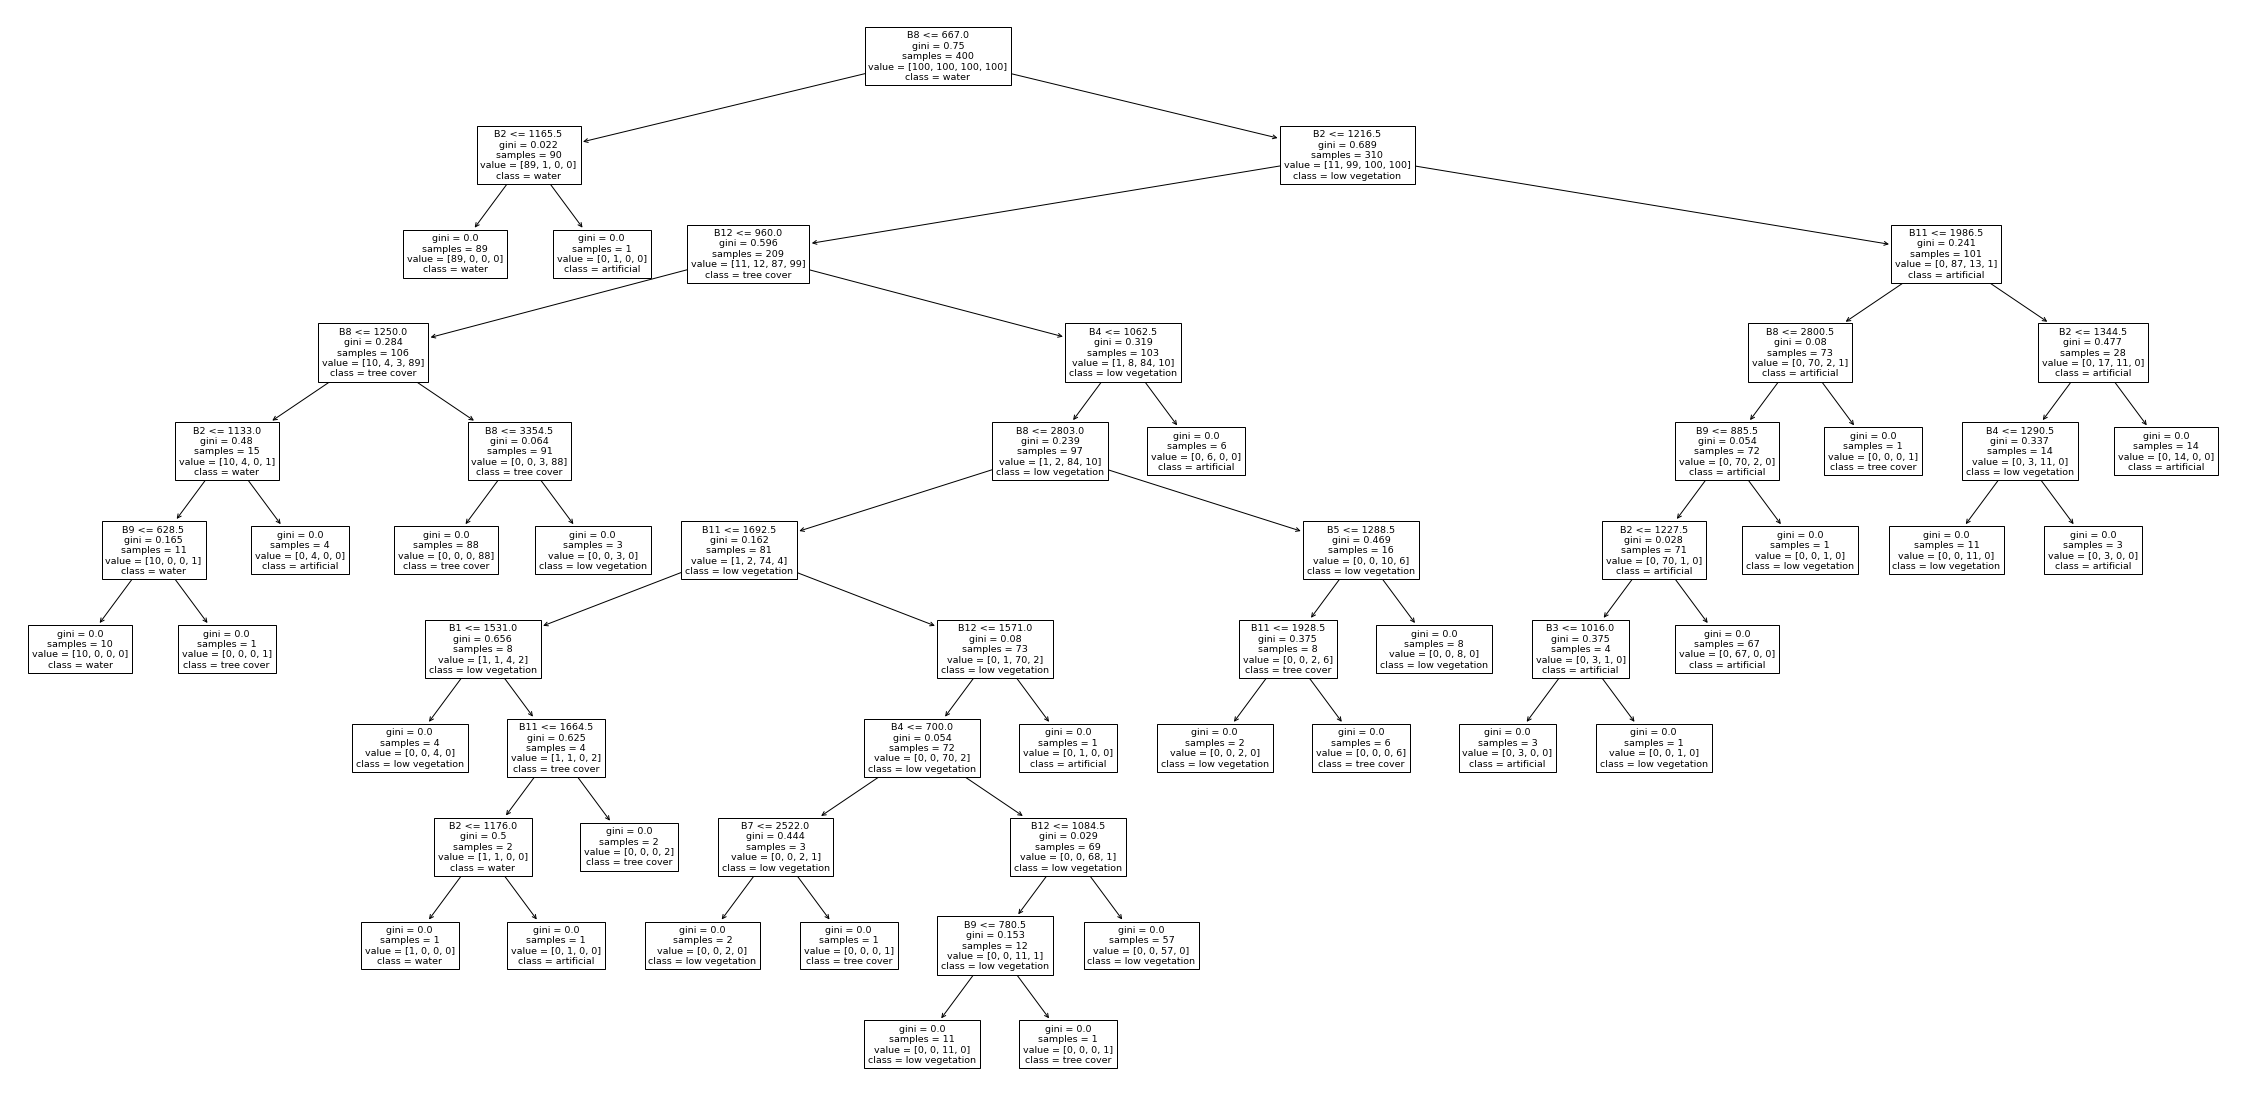

In [17]:
# Visualize the trained decision tree
fig = plt.figure(figsize=(40, 20))
sklearn.tree.plot_tree(dt_clf, feature_names=band_names, class_names=class_names)
plt.show()

<br>

### 4.2 Train a Random Forest classifier

The next example defines and trains a `RandomForestClassifier`. Random Forest is a very common algorithm used for supervised classification. Instead of fitting only one decision tree, sub-samples of the dataset are fit to a number of decision tree classifiers. We use the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class from scikit-learn's `ensemble` module. The following hyperparameters are defined:

* `n_estimator`: number of trees per forecast
* `max_depth`: the maximum depth of the tree
* `random_state`: controls the randomness of the bootstrapping of the samples during the tree building process

In [18]:
rf_clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=0)
rf_clf.fit(X_sup, np.ravel(y))

RandomForestClassifier(max_depth=5, n_estimators=10, random_state=0)

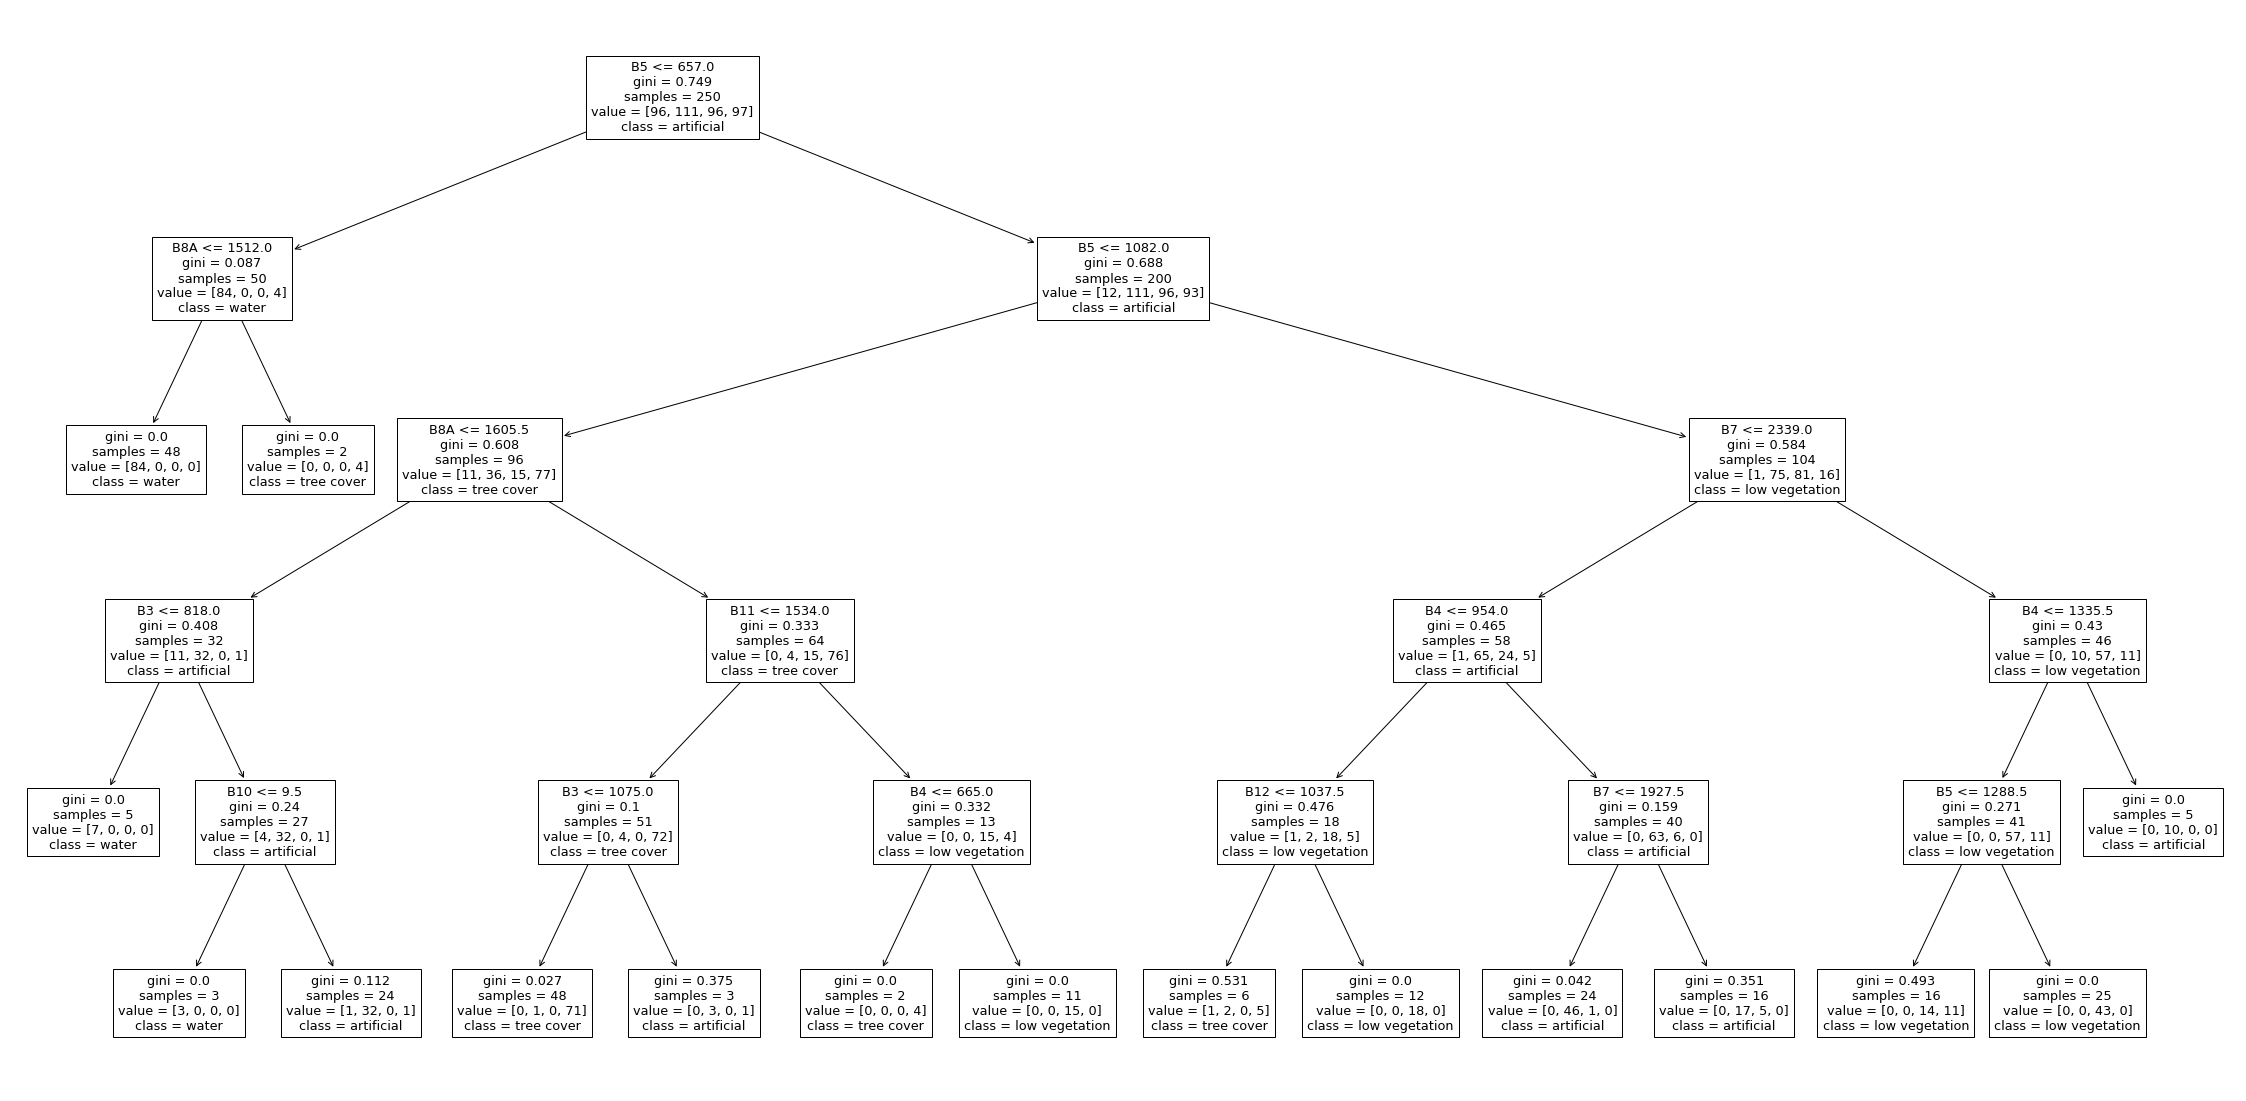

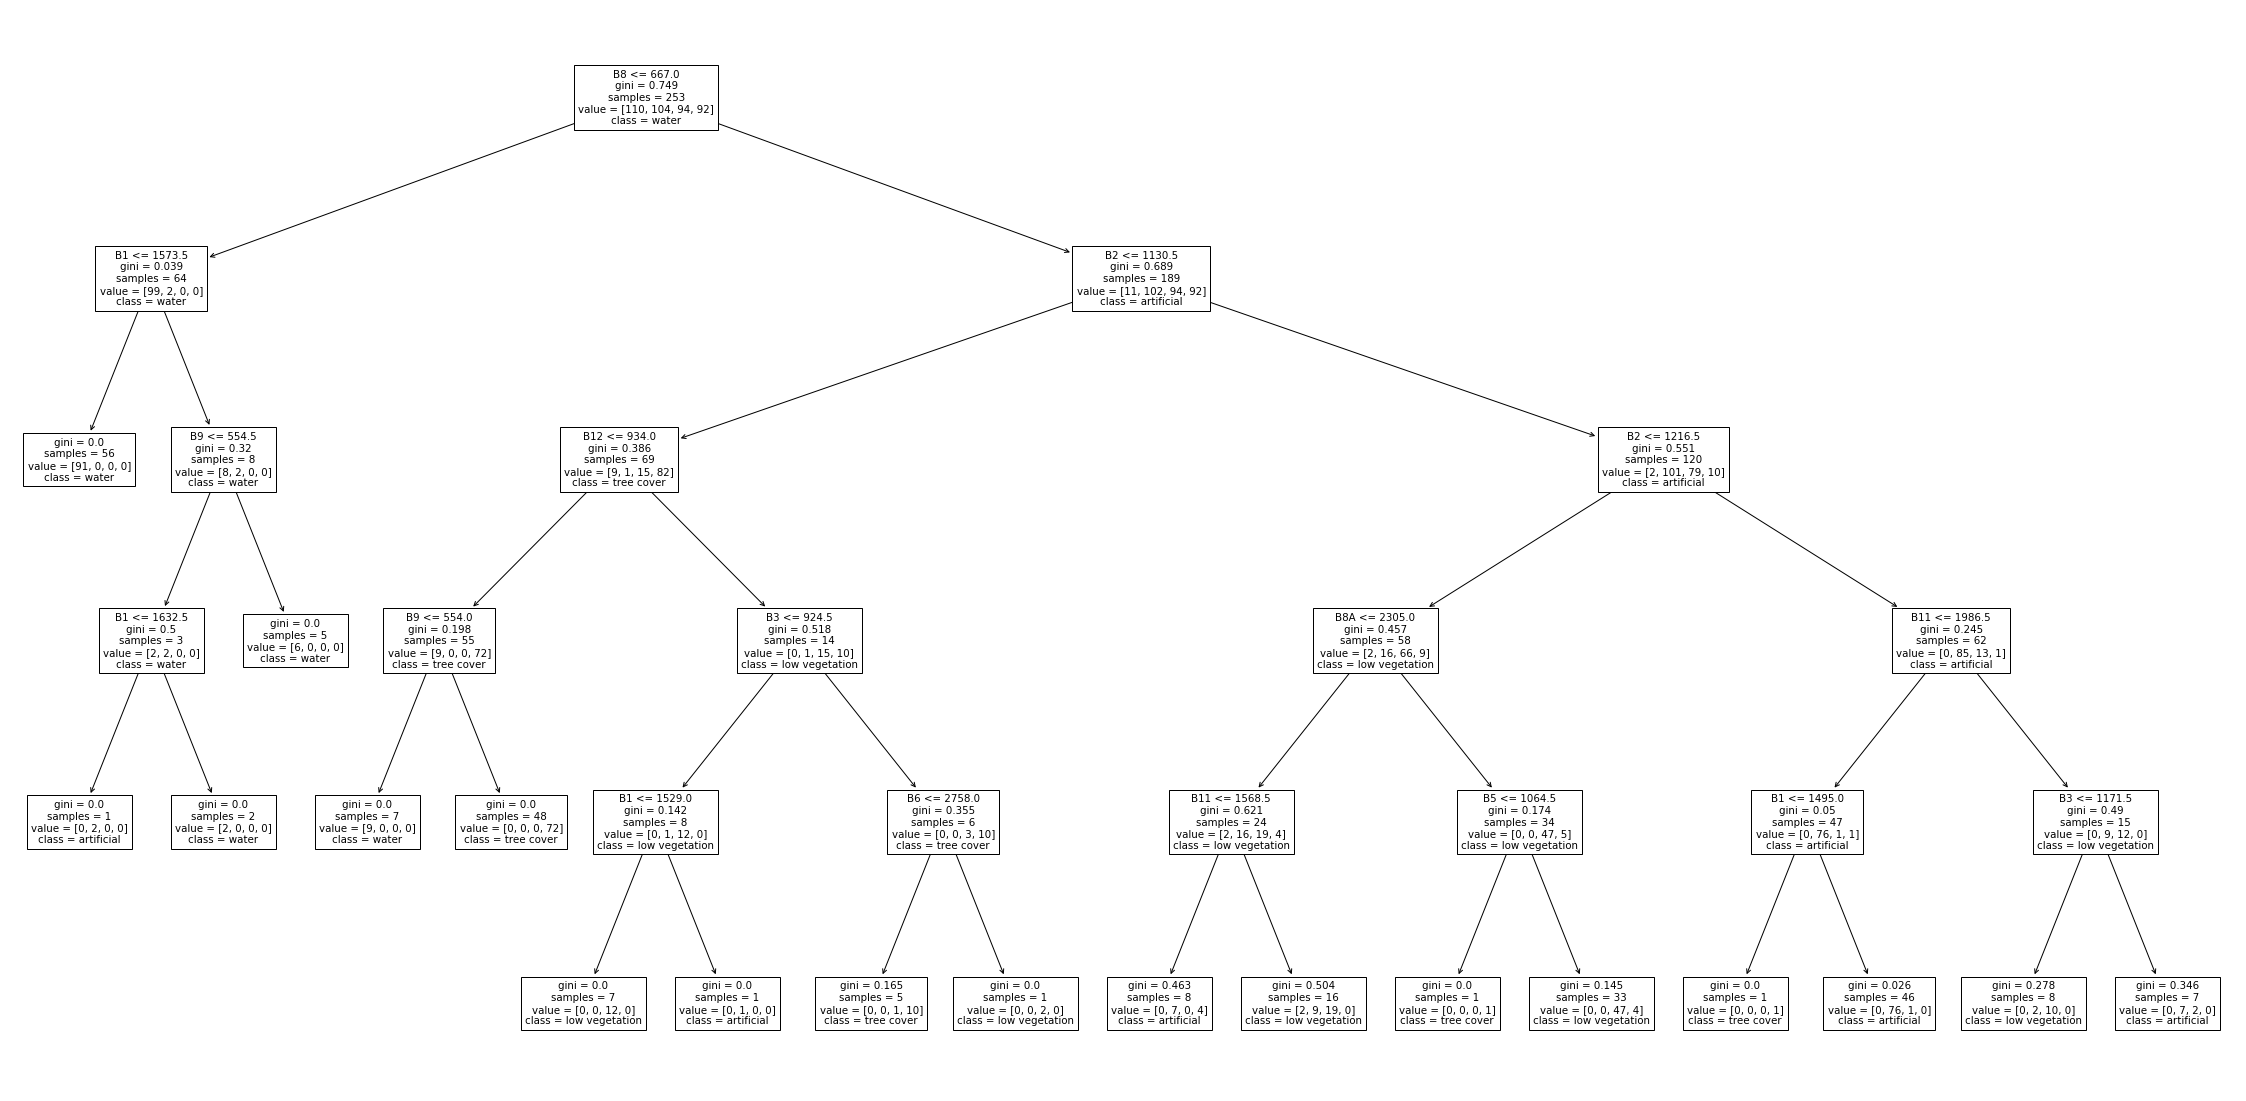

In [19]:
# Visualize the first N trees in the fitted classifier
N = 2

for i in range(N):
    fig = plt.figure(figsize=(40, 20))
    sklearn.tree.plot_tree(
        rf_clf.estimators_[i], feature_names=band_names, class_names=class_names
    )
    plt.show()

<br>

### 4.3 Train a Support Vector Machine classifier

As a last classifier, we define and train a [Support Vector Machine (SVM)](https://scikit-learn.org/stable/modules/svm.html). `SVM` is a classifier which builds a hyperplane feature space to separate classes. The [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) is a support vector classification.

In [20]:
svm_clf = sklearn.svm.SVC()
svm_clf.fit(X_sup, np.ravel(y))

SVC()

<br>

## <a id='kmeans_clustering_3d2'></a>5. Unsupervised classification with K-means clustering

We now train the unsupervised [K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) algorithm. The training dataset is the entire image, with each pixel being a sample and the features being the 13 band intensities. This dataset is the 120,000x13 array `X_all`.

Hyperparameters used:

* `n_clusters`: the number of clusters that shall be formed. Better results are achieved if a greater number of clusters than desired land cover classes are defined
* `random_state`: determines random number generation for centroid initialization 
* `algorithm`: the K-means algorithm type to use, can be 'auto', 'full' or 'elkan'

The output of the prediction is a numpy array with 120,000 rows containing an integer in `[0,9]`.

In [21]:
kmeans = KMeans(n_clusters=10, random_state=2, algorithm="full")

Y_pred_km = kmeans.fit_predict(X_all)
Y_im_km = Y_pred_km.reshape(image[1].shape)
Y_pred_km.shape, Y_im_km.shape

((120000,), (200, 600))

Visualize the original and classified image next to each other.

Text(0.5, 1.0, 'clustering results')

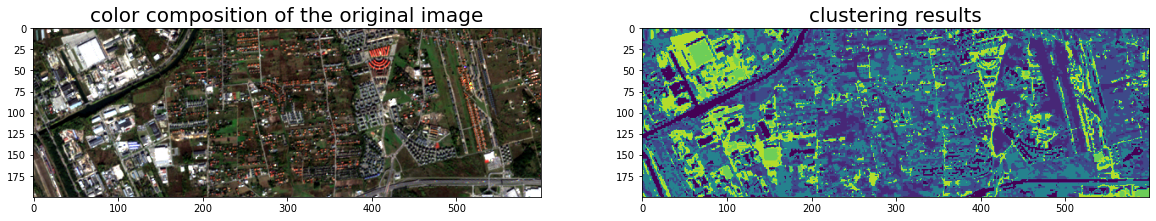

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(rgb_img)
axes[0].set_title("color composition of the original image", size=20)
axes[1].imshow(Y_im_km)
axes[1].set_title("clustering results", size=20)

Visualize the ten individual clusters.

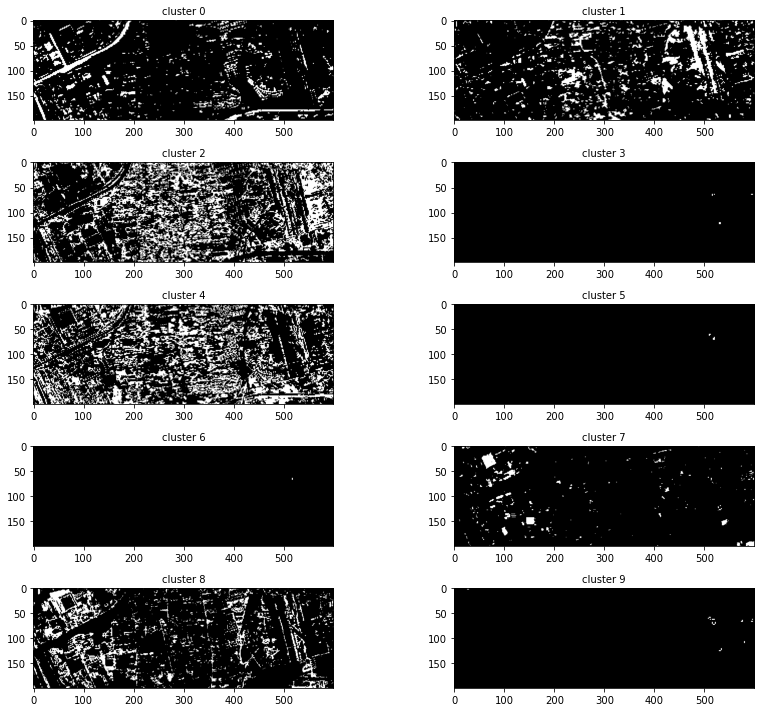

In [23]:
fig, axes = plt.subplots(5, 2, figsize=(12, 10))

cluster = 0

for row in range(0, 5):
    for col in range(0, 2):
        ax = axes[row, col]
        ax.imshow(Y_im_km == cluster, cmap="gray")
        ax.set_title(f"cluster {cluster}", size=10)
        cluster += 1

plt.tight_layout()

## <a id='assign_clusters_3d2'></a>6. Assigning clusters to land cover classes

The next step is to manually assign a cluster to one of the four land cover classes. A visual inspection of the clusters above helps to assign the clusters to the following land cover classes:

* `1 - Water`: cluster 5
* `2 - Artificial surfaces`: clusters 2, 3, 4, 6, 7, 8
* `3 - Low vegetation`: clusters 1, 9
* `4 - Tree cover`: cluster 0

For the assigment, we build a numpy array with the same shape as the classified image and then assign for each pixel the cluster number with the respective number of the land cover class.

In [24]:
Y_class_km = np.zeros(Y_im_km.shape)
clusters_to_band = [
    ([5], 1),
    ([2, 3, 4, 6, 7, 8], 2),
    ([1, 9], 3),
    ([0], 4),
]

for clusters, band in clusters_to_band:
    Y_class_km[np.isin(Y_im_km, clusters)] = band

## <a id='predict_3d2'></a>7. Classification of the Sentinel-2 image with the trained classifiers

Having trained the classifiers, we use the trained models to classify the land cover of the Sentinel-2 image inspected at the beginning of the workflow. We use the array `X_all` the Sentinel-2 image bands as columns with one pixel per row.

We now classify the Sentinel-2 image into the four land cover classes using our three fitted models.

In [25]:
# prediction using trained Decision Tree classifier
Y_pred_dt = dt_clf.predict(X_all)
Y_pred_dt.shape

(120000,)

The resulting array `Y_pred_dt` has a shape of 120,000 rows, containing the predicted land cover class for each pixel of the flattend Sentinel-2 image. In order to visualize the predictions we reshape the array into the shape of the original Sentinel-2 image, `(200, 600)`.

In [26]:
Y_im_dt = Y_pred_dt.reshape(image[1].shape)
Y_im_dt.shape

(200, 600)

In [27]:
# Repeat inference process with the trained Random Forest model
Y_pred_rf = rf_clf.predict(X_all)
Y_im_rf = Y_pred_rf.reshape(image[1].shape)

# Repeat inference process with the trained SVC model
Y_pred_svm = svm_clf.predict(X_all)
Y_im_svm = Y_pred_svm.reshape(image[1].shape)

Next, we plot first the `original` True-Color-composite followed by the predicted land cover classifications for each model, with a legend helping to interpret the land cover classes.

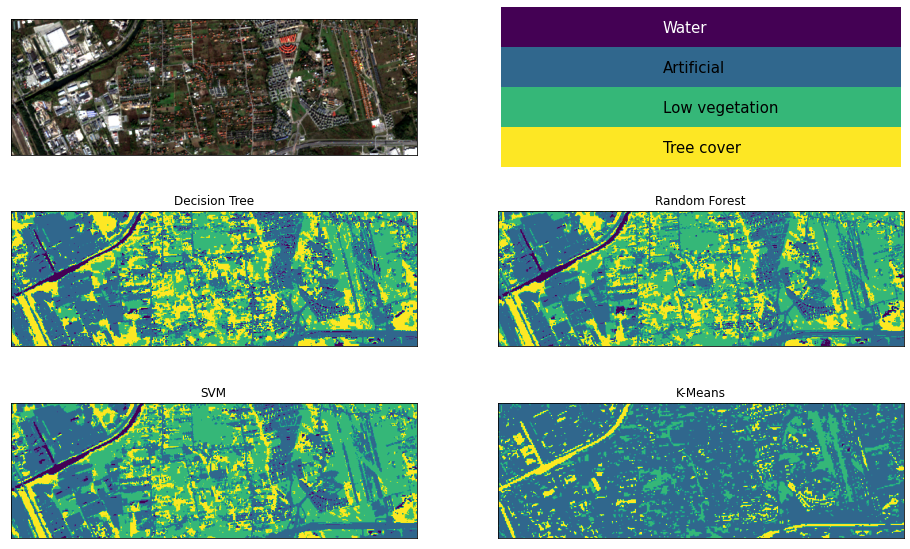

In [28]:
fig, axes = plt.subplots(3, 2, figsize=(16, 10))

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

fig.patch.set_facecolor("white")

_ = axes[0, 0].imshow(rgb_img)
_ = axes[1, 0].imshow(Y_im_dt)
_ = axes[1, 1].imshow(Y_im_rf)
_ = axes[2, 0].imshow(Y_im_svm)
_ = axes[2, 1].imshow(Y_class_km)
_ = utils.plot_classes_legend(axes[0, 1])

_ = axes[1, 0].set_title("Decision Tree")
_ = axes[1, 1].set_title("Random Forest")
_ = axes[2, 0].set_title("SVM")
_ = axes[2, 1].set_title("K-Means")

We see that the supervised models produce approximately the same predications, while K-means differs significantly. In particular it classifies the majority of water pixels as tree cover and a large fraction of tree cover pixels as artificial.

<br>

## <a id='evaluate_3d2'></a>8. Evaluate the classification performance

The last step is to evaluate the performance of the three classifiers in order to better assess the accuracy of the land cover predictions. The evaluation is done with a set of 100 independent `validation` data points, which were manually selected as validation labels.

The first step is to load the 100 validation data points, from [validation_points.csv](../data/validation_data/validation_points.csv). The validation data consists of 100 rows and three columns:

* `x`: the vertical pixel coordinate of the validation point
* `y`: the horizontal pixel coordinate of the validation point
* `class_name`: the land cover class

We encode the class names to the same integer values used when training in an additional column `class_enc`.

In [29]:
p_val = pd.read_csv(VALIDATION_DATA)
p_val["class_enc"] = p_val.class_name.map(class_encoding)
p_val.head()

x    y  class_name  class_enc
0   34  163  artificial          2
1  145  261  artificial          2
2  195  540       water          1
3   16  172  tree cover          4
4   62  279  artificial          2

The validation data does not represent all classes equally. This should be rectified for a more accurate measure of the model's performance across the all classes.

In [30]:
p_val.groupby("class_name").class_name.count()

class_name
artificial        48
low vegetation    34
tree cover        14
water              4
Name: class_name, dtype: int64

Let us visualize the `validation` points on top of the original Sentinel-2 image. You can see that the validation points are equally distributed across the image.

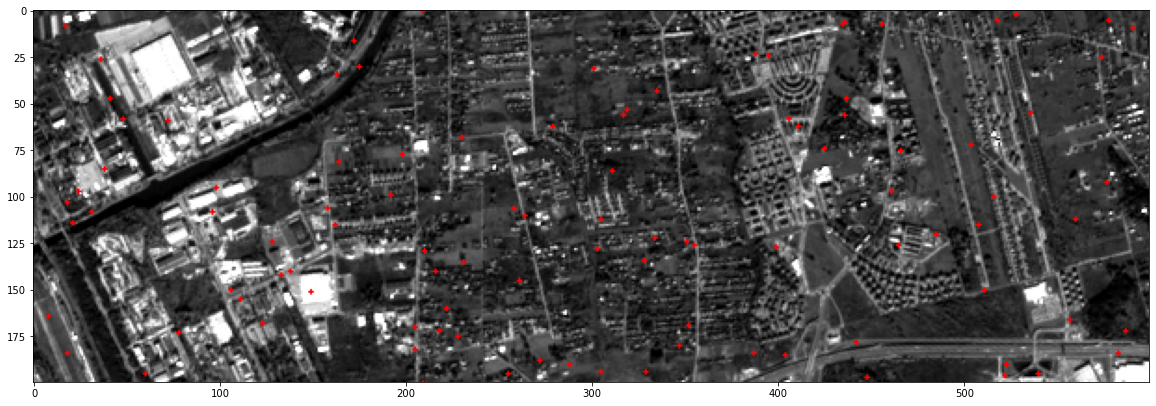

In [31]:
grayscale_img = utils.image_to_grayscale(rgb_img)
utils.add_points_to_image(grayscale_img, p_val, "red")
utils.imshow(grayscale_img)

<br>

Now, with the help of the validation points, we can evaluate the accuracy of the three land cover classifications. Two common metrics to evaluate supervised classifications are `overall accuracy` and `confusion matrix`. Both metrics compare the true and predicted land cover classes for each of the validation pointfor each of the validation point locations.

As a first step, for each of the validation points, we need to retrieve the predicted land cover class from each of the three classifiers.

In [32]:
pred_dt = Y_im_dt[p_val.x, p_val.y]  # Decision Tree
pred_rf = Y_im_rf[p_val.x, p_val.y]  # Random Forest
pred_svm = Y_im_svm[p_val.x, p_val.y]  # SVM
pred_km = Y_class_km[p_val.x, p_val.y]  # K-Means

First, we calculate the [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) for each of the three classifiers. You can use the function `accuracy_score()` from scikit-learn's `metrics` module.

In [33]:
ovAcc_dt = sklearn.metrics.accuracy_score(p_val.class_enc, pred_dt)
ovAcc_rf = sklearn.metrics.accuracy_score(p_val.class_enc, pred_rf)
ovAcc_svm = sklearn.metrics.accuracy_score(p_val.class_enc, pred_svm)
ovAcc_km = sklearn.metrics.accuracy_score(p_val.class_enc, pred_km)

print("Model\t\tOverall accuracy")
print(f"Decision Tree\t{100 * ovAcc_dt}%")
print(f"Random Forest\t{100 * ovAcc_rf}%")
print(f"SVM\t\t{100 * ovAcc_svm}%")
print(f"K-Means\t\t{100 * ovAcc_km:.2f}%")

Model		Overall accuracy
Decision Tree	81.0%
Random Forest	85.0%
SVM		85.0%
K-Means		58.00%


We see that the three supervised models achieve a similar level accuracy on the new data. On the other hand the unsupervised K-means algorithm does significantly worse. This is to be expected since we provide less information when training the model.

Another evaluation score is the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). A confusion matrix helps you to better understand, which land use classes are classified well by a trained classifier and which ones are falsely classified.

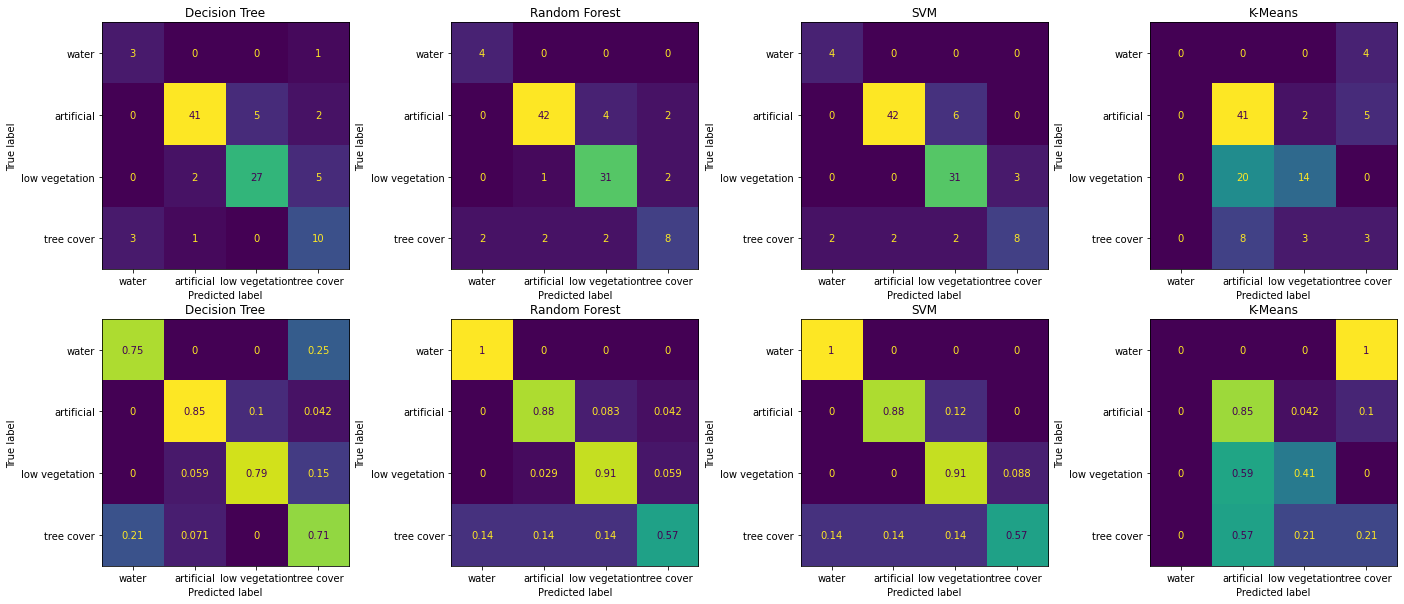

In [34]:
def plot_confusion_matrix(ax, conf_matrix, class_names, title) -> None:
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(title)


conf_matrix = functools.partial(sklearn.metrics.confusion_matrix, p_val.class_enc)
conf_dt = conf_matrix(pred_dt)
conf_rf = conf_matrix(pred_rf)
conf_svm = conf_matrix(pred_svm)
conf_km = conf_matrix(pred_km)
conf_dt_n = conf_matrix(pred_dt, normalize="true")
conf_rf_n = conf_matrix(pred_rf, normalize="true")
conf_svm_n = conf_matrix(pred_svm, normalize="true")
conf_km_n = conf_matrix(pred_km, normalize="true")

fig, axes = plt.subplots(2, 4, figsize=(24, 10))
plot_confusion_matrix(axes[0, 0], conf_dt, class_names, "Decision Tree")
plot_confusion_matrix(axes[0, 1], conf_rf, class_names, "Random Forest")
plot_confusion_matrix(axes[0, 2], conf_svm, class_names, "SVM")
plot_confusion_matrix(axes[0, 3], conf_km, class_names, "K-Means")
plot_confusion_matrix(axes[1, 0], conf_dt_n, class_names, "Decision Tree")
plot_confusion_matrix(axes[1, 1], conf_rf_n, class_names, "Random Forest")
plot_confusion_matrix(axes[1, 2], conf_svm_n, class_names, "SVM")
plot_confusion_matrix(axes[1, 3], conf_km_n, class_names, "K-Means")

We see that:

- the decision tree performs slightly worse on water, artificial and low vegetation and slightly better on tree cover
- all models perform poorly on the tree cover class
- K-means performs very poorly for water, artificial and low vegetation